# CSCI587 - Assignment \#2

The objective of this assignment is to design and implement an in memory spatial network index structure that is used in Spatial Network Databases (SNDB), following the framework presented in this paper: [Link to paper.](https://www.vldb.org/conf/2003/papers/S24P02.pdf)
To test and evaluate the performance of the index structure, you will need to implement the spatial nearest neighbor queries following the Incremental Euclidean Restriction (IER) and Incremental Network Expansion (INE) methods.

In the following you will be given step-by-step instructions on how to implement these. Your task is to filling in the missing parts as indicated by `
``### ADD YOUR CODE HERE``. Ensure the code is well-documented and follows the structure provided.

In [430]:
### Install dependencies

!pip install geopandas
!pip install osmnx
!pip install rtree

## Step 1- Download the POI and Road-Network Data for San Francisco Area

For this assignment, we will use Point-of-Interest data and the underlying road network of San Fransisco City as provided by OpenStreat Map (OSM). The POI data includes various locations such as restaurants, hotels, and landmarks, while the road network represents the streets and intersections of the city.

This step is already implemented for you. You will need to run the following cells to download and store the data.


#### Download the Road Network data

We download the road network of San Fransisco using the osmnx package.

In [431]:
import osmnx as ox
import geopandas as gpd
import os

# Download data if not already stored
if not os.path.exists('sf-road_network.graphml'):

  # Specify area as San Francisco, CA
  G = ox.graph_from_place('San Francisco, California, USA', network_type='drive', simplify=True) # set to simplify=True for a less nodes

  # Plot the road network
  ox.plot_graph(G)

  # Save the graph
  ox.save_graph_geopackage(G, filepath='sf-road-network.gpkg')
  ox.save_graphml(G, filepath='sf-road_network.graphml')

else:

  # Load data from the file
  G = ox.load_graphml('sf-road_network.graphml')

G = ox.project_graph(G, to_crs='EPSG:32610')

# Extract the nodes and edges from the graph
# nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

edges_gdf = edges_gdf.reset_index()

print("Nodes columns:", nodes_gdf.columns)
print("Edges columns:", edges_gdf.columns)

print("edges_gdf CRS:", edges_gdf.crs)
print("edges_gdf EPSG:", edges_gdf.crs.to_epsg())

print("nodes_gdf CRS:", nodes_gdf.crs)
print("nodes_gdf EPSG:", nodes_gdf.crs.to_epsg())

Nodes columns: Index(['y', 'x', 'street_count', 'highway', 'ref', 'railway', 'geometry'], dtype='object')
Edges columns: Index(['u', 'v', 'key', 'osmid', 'highway', 'lanes', 'maxspeed', 'name',
       'oneway', 'ref', 'reversed', 'length', 'bridge', 'tunnel', 'geometry',
       'access', 'width', 'junction'],
      dtype='object')
edges_gdf CRS: EPSG:32610
edges_gdf EPSG: 32610
nodes_gdf CRS: EPSG:32610
nodes_gdf EPSG: 32610


#### Download the POI data for San Francisco Area

Here, we make sure that the POIs are within the road network bounding box.

From this part of the code you will obtain an ``attractions_gdf`` dataframe that holds all POIs of San Francisco.

In [432]:
from shapely.geometry import box

# Chek if data is already stored
if not os.path.exists('sf-attractions.geojson'):

  tags = {'tourism': True, 'amenity': True}

  # Load tourist attractions in San Francisco
  attractions = ox.features.features_from_place('San Francisco, California, USA', tags)

  # Plot the tourist attractions
  attractions = attractions[['name', 'geometry']]
  attractions_gdf = gpd.GeoDataFrame(attractions, geometry='geometry')

  # Get the bounding box of the road network
  minx, miny, maxx, maxy = edges_gdf.total_bounds

  # Create a bounding box polygon
  bounding_box = box(minx, miny, maxx, maxy)

  # Convert the bounding box to a GeoDataFrame
  bounding_box_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'], crs=edges_gdf.crs)

  # Ensure the POIs and road network have the same Coordinate Reference System
  if attractions_gdf.crs != edges_gdf.crs:
      attractions_gdf = attractions_gdf.to_crs(edges_gdf.crs)

  # Filter the POIs to keep only those within the bounding box
  attractions_in_bbox = attractions_gdf[attractions_gdf.within(bounding_box)]

  # Drop non-Point geometries
  attractions_in_bbox = attractions_in_bbox[attractions_in_bbox.geom_type == 'Point']

  # Add x and y coordinates as seperate columns
  attractions_in_bbox['x'] = attractions_in_bbox.geometry.x
  attractions_in_bbox['y'] = attractions_in_bbox.geometry.y

  # Reset index
  attractions_in_bbox = attractions_in_bbox.reset_index(drop=True)

  # Save attractions
  attractions_in_bbox.to_file('sf-attractions.geojson', driver='GeoJSON')


# Load data from the file
attractions_gdf = gpd.read_file('sf-attractions.geojson')

# Reset index
attractions_gdf = attractions_gdf.reset_index(drop=True)

# Plot dataframe
print("Column names in dataframe:", attractions_gdf.columns)
print("Number of POIs:", len(attractions_gdf))

# edges_gdf = edges_gdf.to_crs(epsg=32610)
# nodes_gdf = nodes_gdf.to_crs(epsg=32610)

print("edges_gdf CRS:", edges_gdf.crs)
print("edges_gdf EPSG:", edges_gdf.crs.to_epsg())

print("nodes_gdf CRS:", nodes_gdf.crs)
print("nodes_gdf EPSG:", nodes_gdf.crs.to_epsg())


Column names in dataframe: Index(['name', 'x', 'y', 'geometry'], dtype='object')
Number of POIs: 14565
edges_gdf CRS: EPSG:32610
edges_gdf EPSG: 32610
nodes_gdf CRS: EPSG:32610
nodes_gdf EPSG: 32610


## Part 2- Index Creation

**Time to code!** In this part you will be asked to create the following index structures:

  1.   An R-tree index that stores the POI data

  2.   A network Storage Scheme consisting of the following 3 components
    
    i. Adjacency component, to represent the network connectivity
    
    ii. The poly-line component, to store the the poly-line representation of each segment in the network
    
    iii. An R-tree index that indexes the polylines.




#### Part 2.1. Create an R-Tree index for POI data.

For this part you can use the built in python library rtree.

In [433]:
from rtree import index

# For accurate distance calculations, we project geometris to EPSG:32610 coordinate system.
attractions_gdf = attractions_gdf.to_crs(epsg=32610)

# Build R-tree index for POIs
poi_rtree = index.Index()
for idx, geom in attractions_gdf['geometry'].items():
    # ADD YOUR CODE HERE
    poi_rtree.insert(idx, geom.bounds)

#### Part 2.2.a: Create the adjacency component to represent the network connectivity

Step 1: Define Node Adjacency Entry. In this part you will need to create a node entry. For each node, you will need to store:
 - NBptr: Pointer to the neighbor's adjacency list.
 - distance: Network distance between the current node and the neighbor.
 - MBR: The bounding box (MBR) of the road segment (or edge) between the nodes.
 - PLptr: Pointer to the poly-line data that represents the actual geometry of the road segment.

**Example:** Assuming an edge $e_1$ between two nodes $n_1$ and $n_2$. These nodes are neighbors. An Adjacency Entry for node $n_1$ should hold: A pointer to the adjacency list of $n_2$. The distance between $n_1$ and $n_2$ the MBR of $e_1$ and a pointer to the actual geometry of $e_1$.

In [434]:
### YOUR CODE HERE: Define the node adjacency entry.

### Hint: You can represent this as a class.

from collections import defaultdict

class AdjacencyEntry:
    def __init__(self, NBptr, distance, MBR, PLptr):
        self.NBptr = NBptr       
        self.distance = distance
        self.MBR = MBR
        self.PLptr = PLptr

    def __repr__(self):
        return f"AdjEntry(NBptr={self.NBptr}, dist={self.distance:.1f})"

Step 2: Define Node Representation. Now, each node in the network will have an adjacency list that holds multiple AdjacencyEntry objects, representing their neighbors.

In [435]:
### YOUR CODE HERE: Define the node representation
adjacency_dict = defaultdict(list)

#### Part 2.2.b: Polyline Component. You need a separate structure to store the poly-line geometry of each road segment (or edge). This structure will store the detailed geometry for each road and be referenced by PLptr in the adjacency list.





In [436]:
### YOUR CODE HERE: Define the poly-line component.
polyline_storage = dict()

#### Part 2.2.c. Piecing everything together.

Time to prepare and store tha data!

- Store the Polyline Data: Store the geometry of each road segment in polyline_storage.

- Create the Adjacency Entries and Node Representations. For this step you will need to calculate the distances between the 2 neighboring nodes and the MBR of the edge. For convinience you can use the length of the polyline (``geometry.length``) for distance calculation and the bounds of the polyline (``geometry.bounds``) to extract the MBR.


In [437]:
### YOUR CODE HERE: Create the Adjacency Entries and Node Representations.
for edge_id, row in edges_gdf.iterrows():
    u = row['u']                 
    v = row['v']
    geometry = row['geometry']
    length = geometry.length
    mbr = box(*geometry.bounds)

    polyline_storage[edge_id] = geometry

    entry_uv = AdjacencyEntry(NBptr=v, distance=length, MBR=mbr, PLptr=edge_id)
    adjacency_dict[u].append(entry_uv)

    entry_vu = AdjacencyEntry(NBptr=u, distance=length, MBR=mbr, PLptr=edge_id)
    adjacency_dict[v].append(entry_vu)

#### Part 2.3. Index the polyline MBRs using R-Tree. You will need to index the road segments according to their MBRs

In [438]:
polyline_rtree = index.Index()
### YOUR CODE HERE: Index Poly-line MBR
for edge_id, polyline in polyline_storage.items():
    mbr = polyline.bounds
    polyline_rtree.insert(edge_id, mbr)

print(polyline_rtree)

### Hint: You can retrieve the MBR of a geometry by calling mbr = polyline.bounds

rtree.index.Index(bounds=[542827.4670191165, 4173566.7494925573, 557226.3186780808, 4187318.825802229], size=27578)


## 3- Primitive Functions

In this part, we will implement the premitive functions that are needed to implement the query processing algorithms, as described in the originial VLDB paper. You will need to fill the `TODO` parts.

### 3.1- Primitive SNDB Operations

1. **`check_entity(seg, p, dT)`**: Check if POI `p` lies on segment `seg`, or within a threshold distance `dT`.
2. **`find_segment(p)`**: Outputs the road segment that covers point `p` by performing a point location query on the network R-tree. If multiple segments cover `p`, the first one found is returned.
3. **`find_entities(seg)`**: Returns all POIs that lie in the MBR of `seg`.
4. **`compute_ND(p1, p2)`**: Returns the road network distance from POI `p1` to `p2`.

In [439]:
from shapely.geometry import Point
from shapely.ops import nearest_points
import networkx as nx
import heapq
import numpy as np

def check_entity(seg, p, dT=10):
    """
    Check if POI `p` lies on or near segment `seg` within a threshold distance dT.

    Parameters:
    - seg (Series): A geometry object (LINESTRING) showing the road segment.
    - p (Point): A Point object representing the POI.
    - dT (float): Distance threshold in meters (defaults to 10 meters).

    Returns:
    - bool: True if p lies on or near seg, False otherwise.
    """
    # TODO: Implement the function to return True if the distance between p and seg is less than or equal to dT
    # Hint: You can use Shapely's distance method to easily calculate the distance
    return seg.distance(p) <= dT


def find_segment(p, polyline_idx, roads_gdf, dT=10):
    """
    Output the road segment that covers point `p` by performing a point location query on the network R-tree.
    If multiple segments cover `p`, return the first one.

    Parameters:
    - p (Point): A Shapely Point object representing the query POI.
    - polyline_idx (rtree.index.Index): R-tree index of road network segments.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network edges (segments).
    - dT (float): Distance threshold in meters (defaults to 10 meters).

    Returns:
    - Series: A GeoPandas Series representing the segment that covers or is closest to p.
    """
    # TODO: Implement the function
    # Hint: Use the polyline_idx to find candidate segments near p, check if any segment intersects a buffer around p
    # If none found, find the closest segment to p
    buffer = p.buffer(dT)
    candidate_ids = list(polyline_idx.intersection(buffer.bounds))

    min_dist = float('inf')
    nearest_seg = None

    for edge_id in candidate_ids:
        seg = roads_gdf.loc[edge_id]
        dist = seg.geometry.distance(p)
        if dist <= dT and dist < min_dist:
            min_dist = dist
            nearest_seg = seg

    return nearest_seg


def find_entities(seg, poi_idx, pois_gdf, dT=10):
    """
    Returns all POIs that lie on or near the segment seg.

    Parameters:
    - seg (Series): A LINESTRING geometry data type representing the road segment.
    - poi_idx (rtree.index.Index): R-tree index of POIs.
    - pois_gdf (GeoDataFrame): GeoDataFrame of POIs.
    - dT (float): Distance threshold in meters (default is 10 meters).

    Returns:
    - GeoDataFrame: POIs that lie on or near seg.
    """
    # TODO: Implement the function
    # Hint: Use the poi_idx to find candidate POIs within the MBR of seg, verify each candidate using check_entity(seg, p)
    buffer = seg.buffer(dT)
    mbr = buffer.bounds
    
    candidate_ids = list(poi_idx.intersection(mbr))
    results = []

    for poi_id in candidate_ids:
        poi_point = pois_gdf.loc[poi_id].geometry
        if check_entity(seg, poi_point, dT):
            results.append(pois_gdf.loc[poi_id])

    return gpd.GeoDataFrame(results, crs=pois_gdf.crs) if results else gpd.GeoDataFrame(columns=pois_gdf.columns, crs=pois_gdf.crs)



def compute_ND(p1, p2, G, roads_gdf, polyline_idx):
    """
    Compute the shortest network distance between two points p1 and p2.

    Parameters:
    - p1 (Point): A Shapely Point object representing the starting point.
    - p2 (Point): A Shapely Point object representing the destination point.
    - G: Graph representing the road network.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network edges (segments).
    - polyline_idx (rtree.index.Index): R-tree index of road network segments.

    Returns:
    - float: Network distance between p1 and p2 in meters.
    """
    # TODO: Map p1 and p2 to the nearest nodes or edges in the network using roads_gdf and polyline_idx
    # Compute the shortest path length in G
    seg1 = find_segment(p1, polyline_idx, roads_gdf)
    seg2 = find_segment(p2, polyline_idx, roads_gdf)
    
    if seg1 is None or seg2 is None:
        return float('inf')
    
    if seg1.name == seg2.name:
        return p1.distance(p2)
    
    u1, v1 = seg1['u'], seg1['v']
    u2, v2 = seg2['u'], seg2['v']

    def get_node_coord(nid):
        return Point(G.nodes[nid]['x'], G.nodes[nid]['y'])

    p1_to_u1 = p1.distance(get_node_coord(u1))
    p1_to_v1 = p1.distance(get_node_coord(v1))
    
    p2_to_u2 = p2.distance(get_node_coord(u2))
    p2_to_v2 = p2.distance(get_node_coord(v2))
    
    pq = [(p1_to_u1, u1), (p1_to_v1, v1)]
    visited = {}
    best_dist = float('inf')

    while pq:
        dist, node = heapq.heappop(pq)

        if dist > best_dist:
            continue
        
        if node in visited and visited[node] <= dist:
            continue
        
        visited[node] = dist
        
        if node == u2:
            final_dist = dist + p2_to_u2
            best_dist = min(best_dist, final_dist)
        elif node == v2:
            final_dist = dist + p2_to_v2
            best_dist = min(best_dist, final_dist)
        
        for neighbor in G.neighbors(node):
            if neighbor in visited and visited[neighbor] <= dist:
                continue
            
            edge_data = G.get_edge_data(node, neighbor)
            edge_len = edge_data.get('length', 0)
            if edge_len == 0:
                edge_len = get_node_coord(node).distance(get_node_coord(neighbor))
            
            new_dist = dist + edge_len
            
            if new_dist < best_dist:
                heapq.heappush(pq, (new_dist, neighbor))
    
    return best_dist

## 4- KNN Search Algorithms
In this part, you will implement the IER and INE algorithms for efficient KNN search in spatial network databases.

### 4.1- Incremental Euclidean Restriction (IER) algorithm
Here, we implement the IER algorithm to find the `k` nearest neighbors to query point `q` based on network distance, using Euclidean distance to prune the search space.

The algorithm you need to implement works as follows:
  1. Retrieve the `k` nearest POI neighbors {$p_1,\cdots,p_k$} to `q` based on Euclidean distance using the POI R-tree index.
  2. For each of these candidate neighbors, compute the network distance <code>dN(q,p<sub>i</sub>)</code> using the `compute_ND` function.
  3. Sort the candidates in the ascending order based on their network distance to the query.
  4. Set a threshold <code>d<sub>Emax</sub></code> to the network distance of `k`-th candidate.
  5. Iterate through these steps until no candidate refinement is possible:
    - Fetch the next nearest neighbor `p` based on the Euclidean distance to `q`.
    - If its Euclidean distance `dE(q, p)` is greater than <code>d<sub>Emax</sub></code>, terminate the loop.
    - Otherwise, compute the network distance `dN(q, p)`.
    - if `dN(q, p)` is smaller than <code>dN(q,p<sub>k</sub>)</code>, insert `p` in the candidate set and remove <code>p<sub>k</sub></code>. Update <code>d<sub>Emax</sub></code> accordingly.




In order to implement IER, you need to first implement two additional helper functions, to fetch the Euclidean nearest neighbors. You will use these for your IER implementation.

In [440]:
def euclidean_nn(q, k, poi_idx, pois_gdf):
    """
    Retrieve the k nearest neighbors to the query point q based on Euclidean distance.

    Parameters:
    - q (Point): The query point.
    - k (int): Number of nearest neighbors to retrieve.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.

    Returns:
    - GeoDataFrame: DataFrame containing the k nearest POIs sorted by Euclidean distance.
    """
    # TODO: Implement the function to retrieve the initial k nearest neighbors based on Euclidean distance.
    q_coords = (q.x, q.y, q.x, q.y)
    
    candidate_ids = list(poi_idx.nearest(q_coords, num_results=k * 10))
    
    candidates = []
    for pid in candidate_ids:
        if pid in pois_gdf.index:
            poi = pois_gdf.loc[pid]
            dist = q.distance(poi.geometry)
            candidates.append((pid, dist))
    
    candidates.sort(key=lambda x: x[1])
    
    top_k_count = min(k, len(candidates))
    top_k_ids = [pid for pid, _ in candidates[:top_k_count]]
    
    return pois_gdf.loc[top_k_ids].copy()


def next_euclidean_nn(q, poi_idx, pois_gdf, exclusion_set):
    """
    Retrieve the next nearest neighbor to the query point q based on Euclidean distance, excluding already considered POIs.

    Parameters:
    - q (Point): The query point.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.
    - exclusion_list (set): Set of indices of POIs already considered.

    Returns:
    - Series: The next nearest POI.
    - float: The Euclidean distance to the POI.
    """
    # TODO: Implement the function to retrieve the next nearest neighbor based on Euclidean distance.
    q_coords = (q.x, q.y, q.x, q.y)

    for pid in poi_idx.nearest(q_coords, num_results=len(pois_gdf)):
        if pid in pois_gdf.index and pid not in exclusion_set:
            poi = pois_gdf.loc[pid]
            distance = q.distance(poi.geometry)
            return poi, distance
    
    return None, float('inf')

In [441]:
def IER(q, k, pois_gdf, poi_idx, roads_gdf, polyline_idx, G):
    """
    Incremental Euclidean Restriction (IER) algorithm to find k nearest neighbors based on network distance.

    Parameters:
    - q (Point): The query point.
    - k (int): Number of nearest neighbors to retrieve.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network edges (segments).
    - polyline_idx (rtree.index.Index): R-tree spatial index of the road segments.
    - G (networkx.Graph): The road network graph.

    Returns:
    - knn_list (list): List of k nearest POIs with their network distances.
    """
    # TODO: Implement the IER algorithm.
    initial_candidates = euclidean_nn(q, k, poi_idx, pois_gdf)
    
    distance_cache = {}
    
    def cached_compute_ND(p1, p2):
        poi_id = getattr(p2, 'name', None)
        if poi_id is not None and poi_id in distance_cache:
            return distance_cache[poi_id]
        
        dist = compute_ND(p1, p2, G, roads_gdf, polyline_idx)
        if poi_id is not None:
            distance_cache[poi_id] = dist
        return dist

    result_list = []
    for _, poi in initial_candidates.iterrows():
        dN = cached_compute_ND(q, poi.geometry)
        result_list.append((poi, dN))

    result_list.sort(key=lambda x: x[1])

    dEmax = float('inf')
    if len(result_list) >= k:
        dEmax = result_list[k-1][1]
    
    processed_pois = set([poi.name for poi, _ in result_list])
    
    while True:
        next_poi, dE = next_euclidean_nn(q, poi_idx, pois_gdf, processed_pois)
        if next_poi is None or dE > dEmax:
            break
        processed_pois.add(next_poi.name)
        dN = cached_compute_ND(q, next_poi.geometry)
        if dN < dEmax:
            result_list.append((next_poi, dN))
            result_list.sort(key=lambda x: x[1])
            result_list = result_list[:k]
            dEmax = result_list[k-1][1]

    return result_list[:k]

### 4.2- Incremental Network Expansion (INE) algorithm

In this step, we implement the INE algorithm to find the `k` nearest neighbors to query point `q` based on the network distance, by incrementally expanding the network from `q`.

You should follow these steps to implement the algorithm:
  1. Find the road segment covering or closest to query POI `q` using the earlier `find_segment` function.
  2. Retrieve all POIs that lie on this segment using the `find_entities` function.
  3. Initialize the candidate set {$p_1, ..., p_k$} with these POIs, sorted in ascending order based on their network distance.
  4. If fewer than `k` POIs are found, set the threshold <code>d<sub>Nmax</sub></code> to infinity. Otherwise, set it to the network distance of the `k`-th candidate.
  5. Initialize a priority queue `Q` with the road segment nodes covering `q` and their cumulative network distance from `q`.
  6. While `Q` is not empty and the smallest cumulative distance in `Q` is less than <code>d<sub>Nmax</sub></code> repeat:
    - Dequeue the node `n` with the smallest cumulative network distance.
    - For each non-visited adjacent node `n'` of n:
      - Compute the cumulative network distance <code>d<sub>N</sub>(q, n')</code>.
      - Retrieve all the POIs on the road segment between `n` and `n'` using the `find_entities` function.
      - Add the newly found POIs to the candidate set {$p_1, ..., p_k$}.
      - Update the candidate set so that it contains the `k` POIs with smallest network distance, sorted in ascending order.
      - Update <code>d<sub>Nmax</sub> = d<sub>N</sub>(q,p<sub>k</sub>)</code>
      - Enqueue `n'` into `Q` with its cumulative network distance <code>d<sub>N</sub>(q, n')</code>.
      - Mark `n'` as visited.
  7. Return the resulting top `k` candidate set.


In [442]:
import heapq
import pandas as pd

def INE(q, k, pois_gdf, poi_idx, roads_gdf, polyline_idx, G):
    """
    Incremental Network Expansion (INE) algorithm to find k nearest neighbors based on network distance.

    Parameters:
    - q (Point): The query point.
    - k (int): Number of nearest neighbors to retrieve.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network segments.
    - polyline_idx (rtree.index.Index): R-tree spatial index of the road segments.
    - G (networkx.Graph): The road network graph.

    Returns:
    - knn_list (list): List of k nearest POIs with their network distances.
    """
    # TODO: Implement the INE algorithm
    q_seg = find_segment(q, polyline_idx, roads_gdf)
    if q_seg is None:
        return []

    q_u, q_v = q_seg['u'], q_seg['v']

    distance_cache = {}
    def cached_compute_ND(p1, p2):
        poi_id = getattr(p2, 'name', None)
        if poi_id is not None and poi_id in distance_cache:
            return distance_cache[poi_id]
        dist = compute_ND(p1, p2, G, roads_gdf, polyline_idx)
        if poi_id is not None:
            distance_cache[poi_id] = dist
        return dist

    def get_node_coord(nid):
        return Point(G.nodes[nid]['x'], G.nodes[nid]['y'])

    S_cover = find_entities(q_seg.geometry, poi_idx, pois_gdf, dT=15)
    topk_dict = {}
    visited_pois = set()

    for _, poi in S_cover.iterrows():
        poi_id = poi.name
        dN = cached_compute_ND(q, poi.geometry)
        topk_dict[poi_id] = (poi, dN)
        visited_pois.add(poi_id)

    topk = sorted(topk_dict.values(), key=lambda x: x[1])[:k]
    topk_dict = {p[0].name: p for p in topk}
    dNmax = topk[-1][1] if len(topk) >= k else float('inf')

    pq = []
    for node in [q_u, q_v]:
        dist = q.distance(get_node_coord(node))
        heapq.heappush(pq, (dist, node))

    visited_nodes = set()
    entities_cache = {}

    while pq:
        d_curr, node = heapq.heappop(pq)
        if node in visited_nodes:
            continue
        if d_curr >= dNmax:
            break

        visited_nodes.add(node)

        for neighbor in G.neighbors(node):
            if neighbor in visited_nodes:
                continue

            matching_edges = roads_gdf[
                ((roads_gdf['u'] == node) & (roads_gdf['v'] == neighbor)) |
                ((roads_gdf['u'] == neighbor) & (roads_gdf['v'] == node))
            ]

            for _, edge in matching_edges.iterrows():
                edge_id = edge.name
                if edge_id in entities_cache:
                    pois_on_edge = entities_cache[edge_id]
                else:
                    pois_on_edge = find_entities(edge.geometry, poi_idx, pois_gdf, dT=15)
                    entities_cache[edge_id] = pois_on_edge

                for _, poi in pois_on_edge.iterrows():
                    poi_id = poi.name
                    if poi_id in visited_pois:
                        continue
                    dN = cached_compute_ND(q, poi.geometry)
                    visited_pois.add(poi_id)
                    if len(topk_dict) < k:
                        topk_dict[poi_id] = (poi, dN)
                    elif dN < dNmax:
                        topk_dict[poi_id] = (poi, dN)
                    topk = sorted(topk_dict.values(), key=lambda x: x[1])[:k]
                    topk_dict = {p[0].name: p for p in topk}
                    dNmax = topk[-1][1] if len(topk) >= k else float('inf')

            coord_node = get_node_coord(node)
            coord_neighbor = get_node_coord(neighbor)
            edge_len = coord_node.distance(coord_neighbor)
            heapq.heappush(pq, (d_curr + edge_len, neighbor))

    return sorted(topk, key=lambda x: x[1])

## 6- Analysis and Comparisons

In this part you will need to compare and analyse the different NN methods. To do this, you will need to compare the runtimes of the two methods for the following values of `k` = [1, 5, 10, 15, 20].


In [443]:
minx, miny, maxx, maxy = attractions_gdf.total_bounds
center_point = Point((minx + maxx) / 2, (miny + maxy) / 2)

attractions_gdf['center_dist'] = attractions_gdf.geometry.distance(center_point)
query_point = attractions_gdf.sort_values('center_dist').iloc[0].geometry

print("center coord:", query_point)

center coord: POINT (549974.1216634231 4180436.395294284)


In [444]:
import time
import matplotlib.pyplot as plt

def get_poi_ids(knn_list):
    return [poi.name for poi, _ in knn_list]

def compare_algorithms(q, ks, pois_gdf, poi_idx, roads_gdf, polyline_idx, G):
    ier_times = []
    ine_times = []

    for k in ks:
        start = time.time()
        ier_result = IER(q, k, pois_gdf, poi_idx, roads_gdf, polyline_idx, G)
        # print("ier Done")
        ier_time = time.time() - start

        start = time.time()
        ine_result = INE(q, k, pois_gdf, poi_idx, roads_gdf, polyline_idx, G)
        # print("ine Done")
        ine_time = time.time() - start

        ier_times.append(ier_time)
        ine_times.append(ine_time)

        print("######################### Here is k = ",k, "#########################")

        print("for IER poi id: ", get_poi_ids(ier_result))
        # print("ier time:", ier_time)
        # for poi, dN in ier_result:
        #     x, y = poi.geometry.x, poi.geometry.y
        #     print(f"  → POI: {poi['name']} | Network distance: {dN:.2f} m | UTM location: ({x:.2f}, {y:.2f})")
       
        print("------------")
       
        print("for INE poi id: ", get_poi_ids(ine_result))
        # print("ine time:", ine_time)
        # for poi, dN in ine_result:
        #     x, y = poi.geometry.x, poi.geometry.y
        #     print(f"  → POI: {poi['name']} | Network distance: {dN:.2f} m | UTM location: ({x:.2f}, {y:.2f})")

    return ier_times, ine_times


In [445]:
ks = [1, 5, 10, 15, 20]
query_point = Point(550106, 4180456)
# query_point = Point(549974, 4180456)

# poi_id = 2348
# print(attractions_gdf.loc[poi_id])

# p1 = query_point
# p2 = attractions_gdf.loc[poi_id].geometry 

# network_dist = compute_ND(p1, p2, G, edges_gdf, polyline_rtree)
# print("network dis = ", network_dist)


ier_times, ine_times = compare_algorithms(
    query_point,
    ks,
    pois_gdf=attractions_gdf,
    poi_idx=poi_rtree,
    roads_gdf=edges_gdf,
    polyline_idx=polyline_rtree,
    G=G
)

######################### Here is k =  1 #########################
for IER poi id:  [13748]
------------
for INE poi id:  [13748]
######################### Here is k =  5 #########################
for IER poi id:  [13748, 1375, 8685, 8684, 4993]
------------
for INE poi id:  [13748, 1375, 8685, 8684, 4993]
######################### Here is k =  10 #########################
for IER poi id:  [13748, 1375, 8685, 8684, 4993, 10272, 9931, 1158, 860, 5216]
------------
for INE poi id:  [13748, 1375, 8685, 8684, 4993, 10272, 9931, 1158, 860, 5216]
######################### Here is k =  15 #########################
for IER poi id:  [13748, 1375, 8685, 8684, 4993, 10272, 9931, 1158, 860, 5216, 4994, 2411, 9607, 2412, 9609]
------------
for INE poi id:  [13748, 1375, 8685, 8684, 4993, 10272, 9931, 1158, 860, 5216, 4994, 2411, 9607, 2412, 9609]
######################### Here is k =  20 #########################
for IER poi id:  [13748, 1375, 8685, 8684, 4993, 10272, 9931, 1158, 860, 5216, 4994, 2

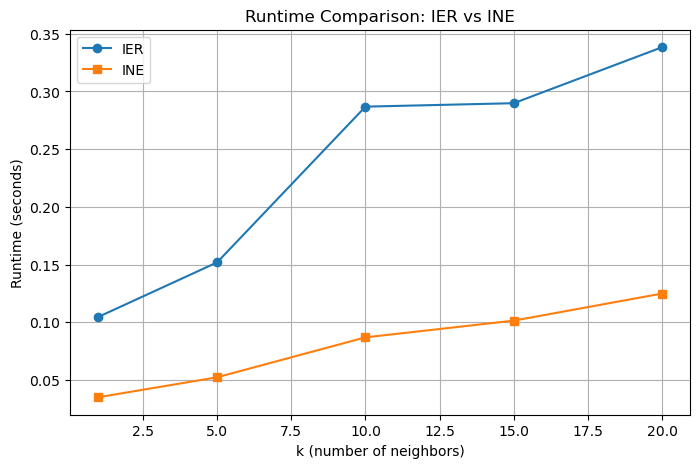

In [446]:
plt.figure(figsize=(8, 5))
plt.plot(ks, ier_times, marker='o', label='IER')
plt.plot(ks, ine_times, marker='s', label='INE')
plt.xlabel("k (number of neighbors)")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime Comparison: IER vs INE")
plt.legend()
plt.grid(True)
plt.show()

## 7- Observations

Are your results aligned with those presented in the paper? Provide a brief summary of your observations below. Include details on any differences or similarities in performance, and discuss any unexpected findings or challenges you encountered during the implementation process.



#### Answer:
The results of my implementation are generally aligned with those presented in the paper. Specifically, for the same query point and the same value of `k`, both IER and INE return the same set of POIs, which confirms the correctness of the algorithms.

In terms of performance, IER takes more time than INE, which is consistent with the paper. However, the time difference between IER and INE is smaller than reported, and the overall running times are higher. I believe this is due to implementation and hardware differences — the paper might use C++ and faster machines, while my implementation is in Python with my own laptop. Besides, the results could also be different based on the different query point and dataset.

One challenge I encountered was in constructing the `adjacency_dict`. At first, I tried to simulate a linked list as in other languages, but later I found that a simple list was enough to represent adjacency in Python. This part caused some confusion initially but was resolved afterward.